# 0. ライブラリのインポート他

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Embedding, merge, Convolution2D, MaxPooling2D, Dropout
from sklearn.cross_validation import train_test_split
from keras.layers.core import Reshape, Flatten
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing import sequence
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import random as rd
import time
import os
from gensim.models.word2vec import Word2Vec
import MeCab
import subprocess
import itertools
import string

Using TensorFlow backend.
/Users/Pikachu/.pyenv/versions/3.4.3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. データ読み込み

In [2]:
#
#ここで各ファイルのパスを設定します。
#

#学習に用いるデータ
csv_file_path = "../input/hoge.csv"

#word2vecのモデル
model_path="../input/word2vec.gensim.model"

#辞書
dic_path="/usr/local/lib/mecab/dic/mecab-ipadic-neologd"

In [3]:
Data = pd.read_csv(csv_file_path)
model = Word2Vec.load(model_path)
tagger = MeCab.Tagger("-Ochasen -d {0}".format(dic_path))

# 2. 分散表現の取得
### word2vecでpre-train

## 2-1. 分かち書き

In [9]:
def _tokenize(text):
    sentence = []
    node = tagger.parse(text)
    #print node
    node = node.split("\n")
    for i in range(len(node)):
        feature = node[i].split("\t")
        if feature[0] == "EOS":
            break
        hinshi = feature[3].split("-")[0]
        if "名詞" in hinshi:
            sentence.append(feature[2].decode('utf-8'))
        elif "形容詞" in hinshi:
            sentence.append(feature[2].decode('utf-8'))
        elif "動詞" in hinshi:
            sentence.append(feature[2].decode('utf-8'))
        elif "形容動詞" in hinshi:
            sentence.append(feature[2].decode('utf-8'))
        elif "連体詞" in hinshi:
            sentence.append(feature[2].decode('utf-8'))
        elif "助詞" in hinshi:
            sentence.append(feature[2].decode('utf-8'))
    return sentence

## 2-2. word2vec

In [9]:
def getVector(text):
    texts = _tokenize(text)
    v = []
    for t in texts:
        if t in model.wv:
            if v == []:
                v = model.wv[t]
            else:
                v = np.vstack((v,model.wv[t]))
    if v != []:
        return v
    else:
        print text
        return np.array([])

In [81]:
countWords = Data["x"].apply(lambda x:getVector(x).shape[0])

/Users/Pikachu/.pyenv/versions/2.7.9/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/Users/Pikachu/.pyenv/versions/2.7.9/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


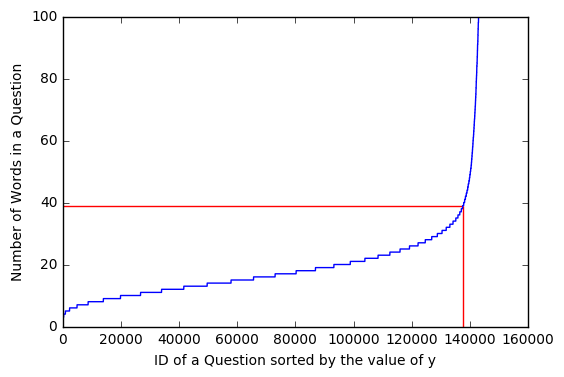

In [85]:
num = countWords.shape[0]
count = countWords.copy().values
count.sort()
plt.axis([0,160000,0,100])
#plt.vlines(x=num,ymin=0,ymax=100,colors='r')
rate=0.95
plt.ylabel("Number of Words in a Question")
plt.xlabel("ID of a Question sorted by the value of y")
plt.vlines(x=int(num*rate),ymin=0,ymax=count[int(num*rate)],colors='r')
#plt.vlines(x=int(num*0.6),ymin=0,ymax=count[int(num*0.6)],colors='r')
#plt.vlines(x=int(num*0.4),ymin=0,ymax=count[int(num*0.4)],colors='r')
#plt.vlines(x=int(num*0.2),ymin=0,ymax=count[int(num*0.2)],colors='r')
plt.hlines(y=count[int(num*rate)],xmin=0,xmax=int(num*rate),color='r')

plt.plot(count)

**上のグラフより、95%のQuestionは、単語数が40以下**

## 2-3. 外れ値の除去

In [ ]:
Data = Data.drop(np.argmax(countWords))
Data = Data.reset_index(drop=True)

In [247]:
#responseとクラスタIDの紐付け
mapping = pd.factorize(Data["y"])
Data["ID"] = mapping[0]
Data.to_csv("../input/Data0.csv",index=False)

## 2-4. Zero Padding
* 単語数 < sequence_length => 末尾に0ベクトルを付け足して長さをsequence_lengthに統一
* 単語数 = sequence_length => そのまま
* 単語数 > sequence_length => 末尾から必要なだけ要素を削って長さをsequence_lengthに統一

In [2]:
Data = pd.read_csv("../input/Data0.csv")

In [8]:
#文の長さ、型(list or np.ndarray)を気にせずdataに突っ込んでいく
data = []
def getJoinedVector(text):
    global data
    texts = _tokenize(text)
    v = []
    one_flg = True
    for t in texts:
        if t in model.wv:
            if v == []:
                v = model.wv[t]
            else:
                one_flg = False
                v = np.vstack((v,model.wv[t]))
    if one_flg:
        v = v[np.newaxis,:]
    return data.append(v)

In [9]:
data = []
Data["x"].apply(lambda x:getJoinedVector(x))

/Users/Pikachu/.pyenv/versions/2.7.9/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
144992    None
144993    None
144994    None
144995    None
144996    None
144997    None
144998    None
144999    None
145000    None
145001    None
145002    None
145003    None
145004    None
145005    None
145006    None
145007    None
145008    None
145009    None
145010    None
145011    None
145012    None
145013    None
145014    None
145015    None
145016    None
145017    None
145018    None
145019    None
145020    None
145021    None
Name: x, dtype: object

In [11]:
#長さをsequence_lengthに統一
sequence_length = 40
data = sequence.pad_sequences(data, maxlen=sequence_length, padding="post", truncating="post",dtype="float32")

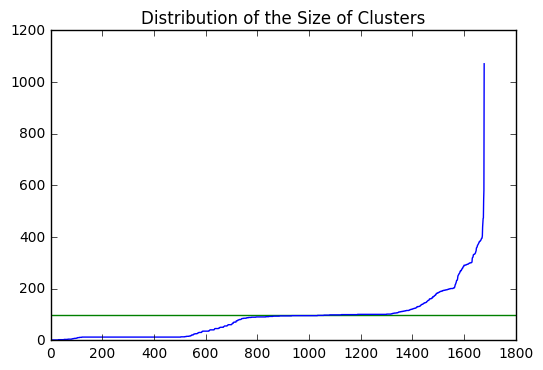

In [19]:
plt.title("Distribution of the Size of Clusters")
plt.plot(np.sort(Data.groupby("ID")["x"].count()))
plt.hlines(y=100,xmin=0,xmax=1800,color='g')

In [14]:
data = data.reshape(len(data),40*50)
pd.DataFrame(data).to_csv("../input/Data1.csv",index=False)

## 2-5. 前処理済みデータの読み込み

In [3]:
data = pd.read_csv("../input/Data1.csv")
Data = pd.read_csv("../input/Data0.csv")

In [5]:
data = data.values.reshape(len(data),40,50)

In [7]:
data.dtype

dtype('float64')

In [8]:
data = data.astype(np.float32)

In [ ]:
#クラスタ数＝回答文のテンプレートの総数
n_clusters = Data["y"].nunique()
clusterID = np.arange(n_clusters)

In [10]:
#trainとtestでclassが均等になるようにsplit
rd.seed(42)
train_index = []
for i in clusterID:
    num = Data[Data["ID"]==i]["ID"].count()
    k = num//2
    train_index.extend(rd.sample(Data[Data["ID"]==i].index,k))

In [11]:
train_X = data[train_index][:,:,:,np.newaxis]
train_y = Data["ID"].values[train_index]
test_X = np.delete(data,train_index,0)[:,:,:,np.newaxis]
test_y = np.delete(Data["ID"].values,train_index,0)

# 3. モデルの実装

In [15]:
#総データ数
m_trains = Data.shape[0]
#窓の幅
filter_sizes = [3,5,7]
#分散表現の次元
vector_length = 50
sequence_length = 40
num_filters = 16
nb_epoch = 1
batch_size = len(train_X)
#centroidsの初期化
np.random.seed(42)
output_dim=50
centroids = np.random.rand(n_clusters,output_dim)

In [17]:
#CNNの設計
inputs = Input(shape=(sequence_length,vector_length,1), dtype='float32')
#embedding = Embedding(output_dim=embedding_dim, input_dim=vocabulary_size, input_length=sequence_length)(inputs)
#reshape = Reshape((sequence_length,embedding_dim,1))(embedding)
conv_0 = Convolution2D(num_filters, filter_sizes[0], vector_length, border_mode='valid', init='normal', activation='relu', dim_ordering='tf')(inputs)
conv_1 = Convolution2D(num_filters, filter_sizes[1], vector_length, border_mode='valid', init='normal', activation='relu', dim_ordering='tf')(inputs)
conv_2 = Convolution2D(num_filters, filter_sizes[2], vector_length, border_mode='valid', init='normal', activation='relu', dim_ordering='tf')(inputs)

maxpool_0 = MaxPooling2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), border_mode='valid', dim_ordering='tf')(conv_0)
maxpool_1 = MaxPooling2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), border_mode='valid', dim_ordering='tf')(conv_1)
maxpool_2 = MaxPooling2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), border_mode='valid', dim_ordering='tf')(conv_2)

merged_tensor = merge([maxpool_0, maxpool_1, maxpool_2], mode='concat', concat_axis=1)
flatten = Flatten()(merged_tensor)
output = Dense(output_dim=output_dim, activation='linear', init='uniform')(flatten)
model = Model(input=inputs, output=output)
#checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

#### 教師ありデータの選び方
* 全クラスタから各k個ずつ

In [18]:
#全クラスタから各k個ずつ選んで、supervisionとして学習に用いる
#教師ありデータのtrain_Xのindex : supervised
k=1
supervised = []
#毎回同じサンプルを抽出、ラベル付け
rd.seed(42)
for i in range(n_clusters):
    supervised.extend(rd.sample(np.arange(len(train_X))[train_y==i],k))
Sup = pd.DataFrame({"train_index":supervised,"label":train_y[supervised]})
#r,label2idの初期化
r = np.array([rd.sample(clusterID,1)[0] for i in range(len(train_X))])
label2id = {i:i for i in clusterID}
#グローバル変数
sup_cent = []
Data.ix[supervised,"ID"].apply(lambda x:sup_cent.append(list(centroids[label2id[x]])))
delta = 0
alpha = 0.01
l = 1.0

## Objective function
$The\; objective\; function\; is\; defined\; as:$

$\quad J_{semi} = \alpha􏰁􏰁\sum_{n=1}^N \sum_{k=1}^K r_{nk}∥f(s_n)−\mu_k∥^2 \\
\quad\quad\quad+(1−α)􏰁\sum_{n=1}^L \{∥f(s_n)−\mu_{g_n}∥^2+\sum_{j\not=g_n}^{} [l+∥f(s_n)−μ_{g_n}∥^2 −∥f(s_n)−μ_j∥^2]_+\}$

$\quad\quad where\; L\; is\; the\; number\; of\; the\; labeled\; data$

$\quad\quad\quad\quad N\; is\; the\; number\; of\; the\; data$

$\quad\quad\quad\quad K\; is\; the\; number\; of\; the\; clusters$

In [19]:
#目的関数の定義
def _cost(true_y,pred_y):
    global centroids,r,sup_pred,supervised,label2id,Data,sup_cent,alpha,l
    supervision = tf.constant(supervised)
    term1 = alpha*tf.reduce_sum(tf.square(pred_y-centroids[r]))
    term1_1 = tf.cast(term1, tf.float32)
    l2_norm = tf.reduce_sum(tf.square(tf.gather(pred_y,supervision) - np.array(sup_cent)), 1)
    term2 = (1-alpha)*tf.reduce_sum(l2_norm)
    l = tf.cast(l, tf.float32)
    term2_1 = tf.cast(term2, tf.float32)
    l2_norm_1 = tf.cast(l2_norm, tf.float32)
    A = tf.add(l,l2_norm_1)
    B = tf.reshape(tf.gather(pred_y,supervision),[tf.gather(pred_y,supervision).get_shape().as_list()[0],1,tf.gather(pred_y,supervision).get_shape().as_list()[1]])
    B_1 = tf.cast(B, tf.float32)
    C = tf.cast(Data.ix[supervised,"ID"].apply(lambda x:np.delete(centroids,label2id[x],0)).values[0][np.newaxis,:,:],tf.float32)
    term3 = tf.reshape(A,[A.get_shape().as_list()[0],1])-tf.reduce_sum(tf.square(B_1-C), 2)
    condition = tf.greater(term3,0)
    term3_1 = tf.select(condition,term3,tf.zeros_like(term3))
    term3_2 = tf.reduce_sum(term3_1)
    term3_3 = tf.cast(term3_2, tf.float32)
    return tf.add(tf.add(term1_1,term2_1),term3_3)

In [20]:
model.compile(optimizer=adam, loss=_cost)

# 4. 学習

In [23]:
def train(train_X,train_y,supervised):
    global centroids,clusterID,Sup,model,epoch,r,sup_pred,label2id,delta,sup_cent,alpha,l
    #1-1.k-NNでラベリング、r（クラスタリング結果）更新
    pred_y = model.predict(train_X)
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(centroids, clusterID)
    #予測されるtrain_XのクラスタID
    r = neigh.predict(pred_y)

    #1-2.ハンガリアンアルゴリズムでラベル付きデータとセントロイドを紐付ける
    sup_pred = pred_y[supervised]
    hg = pd.concat([Sup,pd.DataFrame(sup_pred)],axis=1).groupby("label")[np.arange(output_dim)].mean()
    hglabel = hg.index
    hgx = hg.values
    HgMatrix = np.linalg.norm(hgx[:,np.newaxis,:]-centroids[np.newaxis,:,:],axis=2)
    label2id = {hglabel[i]:np.argmin(HgMatrix[i]) for i in range(len(supervised))}
    Sup["ID"] = Sup["label"].apply(lambda x:label2id[x])
    
    l=1.0
    l2_norm = np.sum(np.square(sup_pred - np.array(sup_cent)), axis = 1)
    delta = (l+l2_norm)[:,np.newaxis]-np.sum(np.square(
            sup_pred[:,np.newaxis,:]-centroids[np.newaxis,:,:]),axis=2)
    delta[delta>0] = 1
    delta[delta<=0] = 0

    #2.centroidsをrを用いて更新    
    for k in range(len(centroids)):
        sum1 = np.sum(alpha*len(np.where(r==k)[0]))
        sum2 = np.sum(alpha*pred_y[r==k])
        delta_k = delta.copy()
        delta_k[:,np.where(np.arange(len(centroids))!=k)] *= -1
        id_of_gn = np.array(map(lambda x:label2id[x],Sup["label"].values))
        delta_k[np.arange(len(supervised)),id_of_gn] = 0
        w = np.sum(delta_k,axis=1)
        w[np.where(id_of_gn == k)] += 1
        w*=(1-alpha)
        sum3 = np.sum(w)
        sum4 = np.sum(w[:,np.newaxis]*sup_pred)
        centroids[k] = (sum2+sum4)/(sum1+sum3)

    #3.NNのパラメータ更新
    sup_cent = []
    Data.ix[supervised,"ID"].apply(lambda x:sup_cent.append(list(centroids[label2id[x]])))
    
    model.fit(train_X, train_y, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)
    
    #以上1~3の繰り返し
    return None

In [27]:
before = model.predict(test_X[0][np.newaxis,:,:,:])
n_epochs = 5
for epoch in range(n_epochs):
    start = time.time()
    train(train_X,train_y,supervised)
    end = time.time()
    print "time: " + str(end - start)+" [s]"
after = model.predict(test_X[0][np.newaxis,:,:,:])

Epoch 1/1
71986/71986 [==============================] - 31s - loss: 4865404.5000
time: 202.310145855 [s]
Epoch 1/1
71986/71986 [==============================] - 40s - loss: 4854832.0000
time: 194.633821011 [s]
Epoch 1/1
71986/71986 [==============================] - 41s - loss: 4850467.5000
time: 206.153919935 [s]
Epoch 1/1
71986/71986 [==============================] - 40s - loss: 4844085.5000
time: 200.651422977 [s]
Epoch 1/1
71986/71986 [==============================] - 33s - loss: 4835860.0000
time: 200.98850584 [s]


# 改善点(するとしたら)
* 「商品名＋とは？」にどう対応するか
 * **ひとまずそのままやる**
* Questionによる単語数の違いにどう対応するか
* _tokenize -> 品詞ふやすor減らす
* ミニバッチ学習できるようにする。

# 参考
* [Semi-supervised Clustering for Short Text via Deep Representation Learning (Wang et al., 2016)](https://arxiv.org/abs/1602.06797)
* [[Python]強化学習(DQN)を実装しながらKerasに慣れる ー　loss関数のカスタマイズ](http://qiita.com/yukiB/items/0a3faa759ca5561e12f8#tips2-loss関数のカスタマイズ)
* [TensorFlow: using a tensor to index another tensor](https://stackoverflow.com/questions/35842598/tensorflow-using-a-tensor-to-index-another-tensor)
